# AGRR: Automatic Gapping Resolution for Russian

**Команда pygirls представляет решение домашнего задания номер 2!**

* Вера Давыдова
* Анастасия Кравцова
* Арина Решетникова

In [1]:
!pip install pymorphy2[fast]

In [2]:
import pandas as pd
import csv
import re
import numpy as np
from gensim import models
from pymorphy2 import MorphAnalyzer
from string import punctuation
from keras import Sequential
from keras.models import Model, Input
from keras.layers import Dense, Dropout, LSTM, Embedding, TimeDistributed, Bidirectional


punct = punctuation+'«»—…“”*№–'
morph = MorphAnalyzer()

Using TensorFlow backend.


### 1.  Подготовка данных

In [3]:
!wget https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/train.csv
!wget https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/test.csv
!wget https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/dev.csv

--2019-05-02 11:00:39--  https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4853915 (4.6M) [text/plain]
Saving to: ‘train.csv.5’

train.csv.5         100%[===================>]   4.63M  --.-KB/s    in 0.1s    

2019-05-02 11:00:39 (43.9 MB/s) - ‘train.csv.5’ saved [4853915/4853915]

--2019-05-02 11:00:41--  https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 606900 (593

In [0]:
train = pd.read_csv('train.csv',sep = '\t', quoting=csv.QUOTE_NONE, encoding='utf-8')
test = pd.read_csv('test.csv',sep = '\t', quoting=csv.QUOTE_NONE, encoding='utf-8')
dev = pd.read_csv('dev.csv',sep = '\t', quoting=csv.QUOTE_NONE, encoding='utf-8')

In [5]:
print('train:')
print('Примеров класса 1: ', int(train['class'].sum()))
print('Примеров класса 0: ', int(len(train['class'])-train['class'].sum()), '\n')
print('test:')
print('Примеров класса 1: ', int(test['class'].sum()))
print('Примеров класса 0: ', int(len(test['class'])-test['class'].sum()), '\n')
print('dev:')
print('Примеров класса 1: ', int(dev['class'].sum()))
print('Примеров класса 0: ', int(len(dev['class'])-dev['class'].sum()), '\n')

train:
Примеров класса 1:  5542
Примеров класса 0:  10864 

test:
Примеров класса 1:  680
Примеров класса 0:  1365 

dev:
Примеров класса 1:  1382
Примеров класса 0:  2760 



### 2. Анализ разметки

In [0]:
train_1 = train[train['class'] != 0]
test_1 = test[test['class'] != 0]
dev_1 = dev[dev['class'] != 0]

train_1.reset_index(drop=True, inplace=True)
test_1.reset_index(drop=True, inplace=True)
dev_1.reset_index(drop=True, inplace=True)

In [0]:
strange_cases = pd.DataFrame(columns=['text', 'class', 'cV', 'cR1', 'cR2', 'V', 'R1', 'R2'])

pattern = re.compile(r'^(\d+:\d+)$')

for index, row in test_1.loc[:,'cV':].iterrows():
    for i in row:
        if not re.match(pattern, str(i)):
            strange_cases = strange_cases.append(test.loc[index])

for index, row in train_1.loc[:,'cV':].iterrows():
    for i in row:
        if not re.match(pattern, str(i)):
            strange_cases = strange_cases.append(train.loc[index])
            
for index, row in dev_1.loc[:,'cV':].iterrows():
    for i in row:
        if not re.match(pattern, str(i)):
            strange_cases = strange_cases.append(dev.loc[index])

In [8]:
strange_cases = strange_cases.drop_duplicates()
print('Всего нестандартных примеров: ', len(strange_cases))

multiple_pairs = strange_cases.dropna(how='any')
print('Число нестандартных примеров, содержащих 2 и более пар оффсетов: ', len(multiple_pairs))

other_cases = pd.DataFrame(columns=['text', 'class', 'cV', 'cR1', 'cR2', 'V', 'R1', 'R2'])
for index, row in strange_cases.iterrows():
    for i in row:
        if 'nan' in str(i):
            other_cases = other_cases.append(row)
            
other_cases = other_cases.drop_duplicates()
unlabeled_counter = 0
for index, row in other_cases.iterrows():
    if str(row['class']) == 'nan':
        unlabeled_counter += 1
        other_cases = other_cases.drop(index)
print('Число нестандартных примеров, в которых отсутствует какой-либо оффсет: ', len(other_cases))

print('Число неразмеченных примеров: ', unlabeled_counter)

Всего нестандартных примеров:  628
Число нестандартных примеров, содержащих 2 и более пар оффсетов:  189
Число нестандартных примеров, в которых отсутствует какой-либо оффсет:  439
Число неразмеченных примеров:  0


### 3. Конвертер разметки-1

In [0]:
def convert(row):
    
    b = True
    I = 'I-'
    O = 'O'
    text = row.text
    num_v = []
  
    cv, cr1 = ('cV', [row.cV.split(':') for row.cV in row.cV.split()]), \
      ('cR1', [row.cR1.split(':') for row.cR1 in row.cR1.split()])

    if type(row.cR2) != float:
        cr2 = ('cR2', [row.cR2.split(':') for row.cR2 in row.cR2.split()])  
    else:
        b = False

    v, r1 = ('V', [row.V.split(':') for row.V in row.V.split()]), \
      ('R1', [row.R1.split(':') for row.R1 in row.R1.split()])
  
    if type(row.R2) != float:
        r2 = ('R2', [row.R2.split(':') for row.R2 in row.R2.split()])
    
    if b:
        tags = [cv, cr1, cr2, v, r1, r2]
    else:
        tags = [cv, cr1, v, r1]
    
    
    tags_dict = {}
    for tag in tags:
        offset = tag[0]
        for i in tag[1]:
            tokens = (text[int(i[0]):int(i[1])]).split()
        for token in tokens:
            tags_dict[token] = I + offset
        
    sentence, tokens = text.split(), []
  
    for i, token in enumerate(sentence):
        token = token.strip(punct)
        tokens.append(token)
        if token in tags_dict.keys():
            sentence[i] = tags_dict[token]
        else:
            sentence[i] = O
            
    return ' '.join(sentence)

In [10]:
def annotate(dataframe=train_1):
  
  annotated = []
  
  for row in dataframe.iterrows():
    try:
        annotated.append(convert(row[1]))
    except AttributeError:
        annotated.append(np.nan)
        continue
  
  return annotated

train_1['io'] = annotate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
train_1.head()

,text,class,cV,cR1,cR2,V,R1,R2,io
0,Работа с двухбайтовыми наборами символов — про...,1,92:99,83:91,103:109,127:127,119:124,127:134,O O O O O O O O O O O O I-R1 I-cR1 I-cV I-R2 I...
1,"Выворачивает наизнанку, запад превращает в юг,...",1,30:40,24:29,41:45,57:57,49:54,57:65,O O I-cR1 I-cV I-R2 I-cR2 O I-R1 O I-R2 I-R2 O...
2,Текущие обязательства компании в 2009 г. сокра...,1,109:120,82:108,121:148,180:180,152:177,180:202,O I-cR1 O O O O O I-R2 O O I-R2 O O I-R2 I-cR1...
3,Первая конвенция была ратифицирована 80 процен...,1,22:36,0:16,37:74,87:87,78:84,87:116,I-cR1 I-cR1 O I-cV I-cR2 I-R2 I-R2 O I-cR2 I-c...
4,"Но Христианин сказал Упрямому: — Нет, сосед, л...",1,105:112,113:139,NaN,156:156,156:169,NaN,O O O O O O O O O O O O O O O O O I-cV O I-cR1...


### 4. Конвертер разметки-2

In [12]:
import copy

def brackets(row):
    """
    Функция для перевода разметки по оффсетам в скобочную запись.
    """
    text = row.text
    new_text = copy.deepcopy(text)
    
    cv = [row.cV.split(':') for row.cV in row.cV.split() if str(row.cV) != 'nan']  
    cr1 = [row.cR1.split(':') for row.cR1 in row.cR1.split() if str(row.cR1) != 'nan']
    if type(row.cR2) != float:
        cr2 = [row.cR2.split(':') for row.cR2 in row.cR2.split() if str(row.cR2) != 'nan'] 
    v = [row.V.split(':') for row.V in row.V.split() if str(row.V) != 'nan']
    r1 = [row.R1.split(':') for row.R1 in row.R1.split() if str(row.R1) != 'nan']
    if type(row.R2) != float:
        r2 = [row.R2.split(':') for row.R2 in row.R2.split() if str(row.R2) != 'nan']
    
    for offset in v:
        new_text = new_text[:int(offset[0])] + "V[] " + new_text[int(offset[1]):]
    
    cv_tokens = [text[int(offset[0]):int(offset[1])] for offset in cv]
    for token in cv_tokens:
        new_token = "cV[ " + token + " cV]"
        new_text = new_text.replace(token, new_token)
            
    cr1_tokens = [text[int(offset[0]):int(offset[1])] for offset in cr1]
    for token in cr1_tokens:
        new_token = "cR1[ " + token + " cR1]"
        new_text = new_text.replace(token, new_token)
        
    cr2_tokens = [text[int(offset[0]):int(offset[1])] for offset in cr2]
    for token in cr2_tokens:
        new_token = "cR2[ " + token + " cR2]"
        new_text = new_text.replace(token, new_token)
    
    r1_tokens = [text[int(offset[0]):int(offset[1])] for offset in r1]
    for token in r1_tokens:
        new_token = "R1[ " + token + " R1]"
        new_text = new_text.replace(token, new_token)
        
    r2_tokens = [text[int(offset[0]):int(offset[1])] for offset in r2]
    for token in r2_tokens:
        new_token = "R2[ " + token + " R2]"
        new_text = new_text.replace(token, new_token)

    return new_text

# Тестируем работу функции
brackets(train_1.iloc[1])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


'Выворачивает наизнанку, cR1[ запад cR1] cV[ превращает cV] cR2[ в юг cR2], а R1[ север R1] — V[] R2[ в восток R2], меняет местами добро и зло, велит открыть своё сердце, ничего не требуя взамен.'

### 5. Бинарная классификация

Воспользовались этим [гайдом](https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1)

Взяли предобученные эмбеддинги с [русвекторес](https://rusvectores.org/ru/models/)

In [13]:
!wget http://vectors.nlpl.eu/repository/11/180.zip
!unzip 180.zip

--2019-05-02 11:01:08--  http://vectors.nlpl.eu/repository/11/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452285 (462M) [application/zip]
Saving to: ‘180.zip.4’

180.zip.4           100%[===================>] 462.01M  22.9MB/s    in 23s     

2019-05-02 11:01:32 (20.4 MB/s) - ‘180.zip.4’ saved [484452285/484452285]

Archive:  180.zip
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: README                  
replace meta.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: meta.json               
replace model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: model.bin               y

replace model.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: model.txt               y
y
y
y
y
y



In [0]:
for index, row in train.iterrows():
    if str(row['class']) == 'nan':
        train = train.drop(index)        
        
for index, row in test.iterrows():
    if str(row['class']) == 'nan':
        test = test.drop(index)

In [0]:
embeddings = models.KeyedVectors.load_word2vec_format(r'model.txt')

In [0]:
def preprocess(text):
    out = []
    words = [word.strip(punct) for word in text.lower().split()] 
    for word in words:
        if word:
            output = '%s_%s' % (morph.parse(word)[0].normal_form, morph.parse(word)[0].tag.POS)
            out.append(output)
    return out

In [0]:
train['lemmas_pos'] = train['text'].apply(preprocess)

In [0]:
test['lemmas_pos'] = test['text'].apply(preprocess)

In [0]:
model=embeddings
def get_vector(sent):  # функция взята из тетрадки семинара по эмбеддингам: 
                       # https://github.com/bakarov/seminars/blob/master/distributional-semantics/distributional-semantics.ipynb
    vector = np.zeros(shape=model.vector_size)
    counter = 0
    for word in sent:
        if word in model.vocab: 
            try:
                vector = np.add(vector, model[word])
                counter += 1
            except KeyError:
                pass
    if counter == 0:
        return vector
    return vector / counter

In [0]:
train['vectors'] = train['lemmas_pos'].apply(get_vector)

In [0]:
test['vectors'] = test['lemmas_pos'].apply(get_vector)

In [22]:
train.head()

,text,class,cV,cR1,cR2,V,R1,R2,lemmas_pos,vectors
0,"Будучи в прошлый четверг в Софии, он назвал се...",0,NaN,NaN,NaN,NaN,NaN,NaN,"[быть_GRND, в_PREP, прошлый_ADJF, четверг_NOUN...","[0.168603191152215, -0.28739759884774685, 0.09..."
1,Работа с двухбайтовыми наборами символов — про...,1,92:99,83:91,103:109,127:127,119:124,127:134,"[работа_NOUN, с_PREP, двухбайтовый_ADJF, набор...","[0.4240986340575748, 0.13711692641178766, 1.37..."
2,"Заместитель Генерального секретаря подчеркнул,...",0,NaN,NaN,NaN,NaN,NaN,NaN,"[заместитель_NOUN, генеральный_ADJF, секретари...","[0.09843469476875137, -0.1834418819669415, 1.6..."
3,Продажа недвижимости из собственных портфелей ...,0,NaN,NaN,NaN,NaN,NaN,NaN,"[продажа_NOUN, недвижимость_NOUN, из_PREP, соб...","[-0.15080114901065828, -0.33817869424819946, -..."
4,"Новым является то, что повышенное давление кон...",0,NaN,NaN,NaN,NaN,NaN,NaN,"[новый_ADJF, являться_VERB, то_CONJ, что_CONJ,...","[1.0187650003481838, -0.013968473164046683, 0...."


In [0]:
X_train = np.stack(train['vectors'], axis=0)
Y_train = np.stack(train['class'], axis=0)

In [24]:
classifier = Sequential()

classifier.add(Dense(500, activation='relu', kernel_initializer='random_normal', input_dim=300))
classifier.add(Dropout(0.5))
classifier.add(Dense(500, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
classifier.fit(X_train,Y_train, batch_size=50, epochs=47)

Instructions for updating:
Use tf.cast instead.
Epoch 1/47
16406/16406 [==============================] - 3s 170us/step - loss: 0.6172 - acc: 0.6755
Epoch 2/47
16406/16406 [==============================] - 2s 111us/step - loss: 0.5666 - acc: 0.7093
Epoch 3/47
16406/16406 [==============================] - 2s 110us/step - loss: 0.5496 - acc: 0.7232
Epoch 4/47
16406/16406 [==============================] - 2s 112us/step - loss: 0.5406 - acc: 0.7308
Epoch 5/47
16406/16406 [==============================] - 2s 110us/step - loss: 0.5270 - acc: 0.7383
Epoch 6/47
16406/16406 [==============================] - 2s 109us/step - loss: 0.5167 - acc: 0.7441
Epoch 7/47
16406/16406 [==============================] - 2s 109us/step - loss: 0.5046 - acc: 0.7549
Epoch 8/47
16406/16406 [==============================] - 2s 108us/step - loss: 0.4959 - acc: 0.7545
Epoch 9/47
16406/16406 [==============================] - 2s 109us/step - loss: 0.4868 - acc: 0.7638
Epoch 10/47
16406/16406 [==================

### 6. Оценка результатов бинарной классификации

In [0]:
X_test = np.stack(test['vectors'], axis=0)
Y_test = np.stack(test['class'], axis=0)

In [0]:
y_pred = classifier.predict_classes(X_test)

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred)

0.7246943765281174

In [0]:
test_out = pd.DataFrame(columns=['text', 'class'])

In [0]:
test_out.text = test.text

In [0]:
test_out['class'] = y_pred

In [32]:
test_out.head()

,text,class
0,Изобретение относится к судостроению и касаетс...,0
1,"Эти состояния называют фазами воды, а превраще...",1
2,И должен ни единой долькой Не отступаться от ...,0
3,Он потребовал обеспечить полное осуществление ...,0
4,"По мнению местного пастора Элла Эбанкса, запре...",0


In [0]:
test_out.to_csv('binary_out.csv', sep='\t', encoding='utf-8')

In [34]:
!wget https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/agrr_metrics.py
!python agrr_metrics.py -b test.csv binary_out.csv

--2019-05-02 11:05:29--  https://raw.githubusercontent.com/artemovae/ML-for-compling/master/homeworks/HW2/agrr_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6101 (6.0K) [text/plain]
Saving to: ‘agrr_metrics.py.7’

agrr_metrics.py.7   100%[===================>]   5.96K  --.-KB/s    in 0s      

2019-05-02 11:05:29 (80.2 MB/s) - ‘agrr_metrics.py.7’ saved [6101/6101]

Binary classification quality (f1-score): 0.5288702928870294
Other metrics: 
 Precision: 0.6135922330097088
 Recall: 0.4647058823529412


### 7. Классификация последовательности

Воспользовались этим [гайдом](https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/)

In [0]:
train_rnn = train_1[['text', 'class', 'io']].dropna(axis='index')
train_rnn.reset_index(drop=True, inplace=True)

In [0]:
test_rnn = test[test['class'] == 1]

In [37]:
train_rnn.shape

(5541, 3)

In [0]:
def lemmatise(text):
    text = [word.strip(punct) for word in text.lower().split()]
    text = [morph.parse(word)[0].normal_form for word in text if word]
    
    return text

In [39]:
train_rnn['lemmas'] = train_rnn.text.apply(lemmatise)
test_rnn['lemmas'] = test_rnn.text.apply(lemmatise)

train_rnn.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,text,class,io,lemmas
0,Работа с двухбайтовыми наборами символов — про...,1,O O O O O O O O O O O O I-R1 I-cR1 I-cV I-R2 I...,"[работа, с, двухбайтовый, набор, символ, прост..."
1,"Выворачивает наизнанку, запад превращает в юг,...",1,O O I-cR1 I-cV I-R2 I-cR2 O I-R1 O I-R2 I-R2 O...,"[выворачивать, наизнанку, запад, превращать, в..."
2,Текущие обязательства компании в 2009 г. сокра...,1,O I-cR1 O O O O O I-R2 O O I-R2 O O I-R2 I-cR1...,"[текущий, обязательство, компания, в, 2009, го..."
3,Первая конвенция была ратифицирована 80 процен...,1,I-cR1 I-cR1 O I-cV I-cR2 I-R2 I-R2 O I-cR2 I-c...,"[один, конвенция, быть, ратифицировать, 80, пр..."
4,"Но Христианин сказал Упрямому: — Нет, сосед, л...",1,O O O O O O O O O O O O O O O O O I-cV O I-cR1...,"[но, христианин, сказать, упрямый, нет, сосед,..."


In [40]:
from itertools import chain

all_words = set(list(chain.from_iterable(train_rnn.lemmas)) + list(chain.from_iterable(test_rnn.lemmas)))

id2word = {index: word for index, word in enumerate(all_words)}

size_words = len(id2word.items())

print(size_words, *list(id2word.items())[:5], sep='\n')

id2word[size_words] = 'ENDPAD'

18894
(0, 'гейша')
(1, 'usb')
(2, '103,0')
(3, 'кроссовок')
(4, 'выиграть')


In [41]:
test_rnn.head()

,text,class,cV,cR1,cR2,V,R1,R2,lemmas_pos,vectors,lemmas
1,"Эти состояния называют фазами воды, а превраще...",1,14:22,0:13,23:34,81:81,38:78,81:100,"[этот_ADJF, состояние_NOUN, называть_VERB, фаз...","[1.3254939317703247, -0.590305113366672, 1.324...","[этот, состояние, называть, фаза, вода, а, пре..."
7,"Два валяются в воде, два на призовых местах.",1,4:12,0:3,13:19,25:25,21:24,25:43,"[два_NUMR, валяться_VERB, в_PREP, вода_NOUN, д...","[0.001960158348083496, 0.14662458995978037, -1...","[два, валяться, в, вода, два, на, призовой, ме..."
8,В тоже время в обоих двоичных деревьях узел 3 ...,1,46:54,39:45,55:73,86:86,77:83,86:113,"[в_PREP, тоже_ADVB, время_NOUN, в_PREP, оба_NU...","[0.9998672127723693, 0.2926726579666138, 0.056...","[в, тоже, время, в, оба, двоичный, дерево, узе..."
11,Описание структуры CREATESTRUCT приводится ниж...,1,32:42,0:31,43:47,88:88,51:85,88:133,"[описание_NOUN, структура_NOUN, createstruct_N...","[0.5813497773238591, 0.7262205224750298, -0.55...","[описание, структура, createstruct, приводитьс..."
21,"В Библии, в предсказаниях пророка Иоиля сказан...",1,86:97,79:85,98:105,113:113,108:112,113:120,"[в_PREP, библия_NOUN, в_PREP, предсказание_NOU...","[-0.22539916187524794, -0.5959431514143944, 0....","[в, библия, в, предсказание, пророк, иоиль, ск..."


In [0]:
def sent2id(dataframe):
  
  word2id = {word: idx for idx, word in id2word.items()}
  
  sentence2index = [[word2id[word] for word in sentence] for sentence in \
                    dataframe.lemmas.tolist()]
  
  return sentence2index

In [43]:
x = sent2id(dataframe=train_rnn)
test_x = sent2id(dataframe=test_rnn)

print(*x[0])

6874 5347 6628 16832 10023 13205 15288 540 5830 5925 17644 2721 17224 3394 3058 1562 14075 2996 2721 3058 8677


In [44]:
unique_io_tags = set(' '.join(train_rnn.io.tolist()).split())

id2tag = {index: tag for index, tag in enumerate(unique_io_tags)}

print(*list(id2tag.items()), sep='\n')

(0, 'I-cR2')
(1, 'O')
(2, 'I-cR1')
(3, 'I-R1')
(4, 'I-cV')
(5, 'I-R2')


In [45]:
tag2id = {tag: idx for idx, tag in id2tag.items()}
y = [[tag2id[tag] for tag in annotation.split()] for annotation in train_rnn.io.tolist()]
size_tags = len(unique_io_tags)
y[0]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 4, 5, 0, 1, 1, 3, 1, 5, 5]

(array([378., 464., 822., 536., 792., 510., 567., 322., 366., 213., 188.,
         82.,  95.,  59.,  61.,  23.,  22.,   8.,  12.,   3.,   4.,   4.,
          1.,   1.,   2.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  5.  ,   7.48,   9.96,  12.44,  14.92,  17.4 ,  19.88,  22.36,
         24.84,  27.32,  29.8 ,  32.28,  34.76,  37.24,  39.72,  42.2 ,
         44.68,  47.16,  49.64,  52.12,  54.6 ,  57.08,  59.56,  62.04,
         64.52,  67.  ,  69.48,  71.96,  74.44,  76.92,  79.4 ,  81.88,
         84.36,  86.84,  89.32,  91.8 ,  94.28,  96.76,  99.24, 101.72,
        104.2 , 106.68, 109.16, 111.64, 114.12, 116.6 , 119.08, 121.56,
        124.04, 126.52, 129.  ]),
 <a list of 50 Patch objects>)

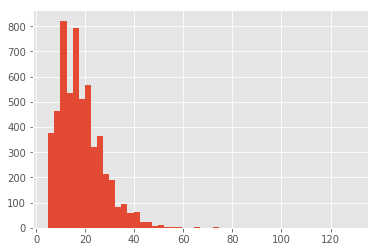

In [46]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.hist([len(s) for s in x], bins=50)

In [0]:
from keras.preprocessing.sequence import pad_sequences

max_len = 50
x_train = pad_sequences(maxlen=max_len, sequences=x, padding='post', value=size_words)
y_train = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2id['O'])
x_test = pad_sequences(maxlen=max_len, sequences=test_x, padding='post', value=size_words)

In [48]:
from keras.utils import to_categorical

y_train = [to_categorical(i, num_classes=size_tags) for i in y_train]
np.array(y_train).shape

(5541, 50, 6)

In [0]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=size_words, output_dim=50, input_length=max_len)(input) 
model = Dropout(0.1)(model) 
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(size_tags, activation="softmax"))(model)
model = Model(input, out)

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 4432 samples, validate on 1109 samples
Epoch 1/10
4432/4432 [==============================] - 39s 9ms/step - loss: 0.7981 - acc: 0.7705 - val_loss: 0.6326 - val_acc: 0.7797
Epoch 2/10
4432/4432 [==============================] - 37s 8ms/step - loss: 0.5611 - acc: 0.7909 - val_loss: 0.4847 - val_acc: 0.8136
Epoch 3/10
4432/4432 [==============================] - 38s 9ms/step - loss: 0.4412 - acc: 0.8275 - val_loss: 0.4492 - val_acc: 0.8254
Epoch 4/10
4432/4432 [==============================] - 38s 8ms/step - loss: 0.3725 - acc: 0.8555 - val_loss: 0.4206 - val_acc: 0.8398
Epoch 5/10
4432/4432 [==============================] - 38s 8ms/step - loss: 0.3199 - acc: 0.8784 - val_loss: 0.4218 - val_acc: 0.8417
Epoch 6/10
4432/4432 [==============================] - 38s 9ms/step - loss: 0.2823 - acc: 0.8933 - val_loss: 0.4244 - val_acc: 0.8448
Epoch 7/10
4432/4432 [==============================] - 38s 9ms/step - loss: 0.2519 - acc: 0.9065 - val_loss: 0.4286 - val_acc: 0.8461
Epoch 8

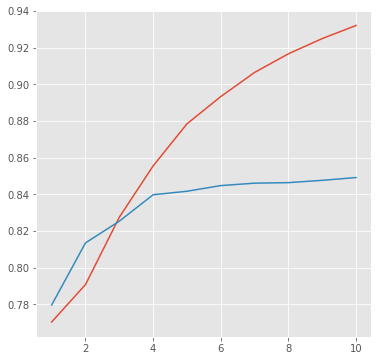

In [51]:
hist = pd.DataFrame(history.history, index=range(1,11))
plt.figure(figsize=(6,6))
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

### 8. Оценка результатов полной разметки

In [52]:
test_rnn['vectors'] = x_test.tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
def predict(vector):
  p = model.predict(np.array([vector]))
  p = np.argmax(p, axis=-1)
  pred_io = [id2tag[pred] for word, pred in zip(vector, p[0]) if id2word[word] != 'ENDPAD']
  return ' '.join(pred_io)

In [54]:
test_rnn['io_prediction'] = test_rnn['vectors'].apply(predict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
test['io_prediction'] = test_rnn['io_prediction']

In [57]:
test.head()

,text,class,cV,cR1,cR2,V,R1,R2,lemmas_pos,vectors,io_prediction
0,Изобретение относится к судостроению и касаетс...,0,NaN,NaN,NaN,NaN,NaN,NaN,"[изобретение_NOUN, относиться_VERB, к_PREP, су...","[0.0062005452811717985, -0.43120876252651213, ...",NaN
1,"Эти состояния называют фазами воды, а превраще...",1,14:22,0:13,23:34,81:81,38:78,81:100,"[этот_ADJF, состояние_NOUN, называть_VERB, фаз...","[1.3254939317703247, -0.590305113366672, 1.324...",O I-cR1 I-cV I-cR2 O O O I-R1 I-R1 I-R1 I-R2 I...
2,И должен ни единой долькой Не отступаться от ...,0,NaN,NaN,NaN,NaN,NaN,NaN,"[и_CONJ, должный_ADJS, ни_PRCL, единый_ADJF, д...","[0.44970626446108025, -0.9549528261025747, -0....",NaN
3,Он потребовал обеспечить полное осуществление ...,0,NaN,NaN,NaN,NaN,NaN,NaN,"[он_NPRO, потребовать_VERB, обеспечить_INFN, п...","[0.5796275761994448, -0.7381095398556102, 0.68...",NaN
4,"По мнению местного пастора Элла Эбанкса, запре...",0,NaN,NaN,NaN,NaN,NaN,NaN,"[по_PREP, мнение_NOUN, местный_ADJF, пастор_NO...","[0.6148717587606775, -0.539965526925193, 1.216...",NaN


In [0]:
test.to_csv('rnn_out.csv', sep='\t', encoding='utf-8')

In [59]:
!python3 agrr_metrics.py test.csv rnn_out.csv

Binary classification quality (f1-score): 0.4210526315789474
Gapping resolution quality (symbol-wise f-measure): 8.241712904616306e-05
